In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import splitfolders
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import numpy as np
from modelfunc import save_model

In [2]:
np.random.seed(123) # set random seed for reproducability

In [3]:
print('Num GPUs Available: ', len(tf.config.list_physical_devices('GPU'))) # make sure GPU is being used

Num GPUs Available:  1


In [4]:
tf.get_logger().setLevel('ERROR') # hide some warning messages

#### Image Parameters

In [5]:
batch_size = 32
img_height = 256
img_width = 256
img_channels = 3

#### Load Datasets

In [6]:
train_split_test_dir='../0. Project Data/Reshaped zero-padded and split data'
train_ds = image_dataset_from_directory(
    train_split_test_dir + '/train',
    image_size=(img_width, img_height),
    batch_size=batch_size)
val_ds = image_dataset_from_directory(
    train_split_test_dir + '/val',
    image_size=(img_width, img_height),
    batch_size=batch_size)
test_ds = image_dataset_from_directory(
    train_split_test_dir + '/test',
    image_size=(img_width, img_height),
    batch_size=batch_size)

Found 2678 files belonging to 4 classes.
Found 667 files belonging to 4 classes.
Found 843 files belonging to 4 classes.


#### Using a Pretrained Model (VGG16)

Here we use part of a pre-trained CNN model(VGG16) that has been trained on the ImageNet dataset which contains over 14 million images. The plan is to take the convolutional base from the VGG16 model which has (ideally) learned some small features that are common between everyday real-world items and discard the densely connected classification layers which have been tuned to classify animals and other objects. In its place we would train our own densely connected layers to taylor its application to our classification task. So ontop of the convolutional base, we add some densely connected layers along with a dropout layer with a softmax activation function output layer. Before we start any training, we freeze the weights on the convolutional base because if we don't, the randomly initialized weights of the densely connected layers will backpropogate and destroy all the learning from our pretrained convolutional base.

#### Take the Convolutional Base of the VGG16 Model

In [7]:
conv_base = keras.applications.vgg16.VGG16(
 weights='imagenet',
 include_top=False)
conv_base.trainable = False # freeze weights

In [8]:
conv_base.summary() # the convolutional base has a pyramid like conv-conv-pooling structure

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [9]:
# enginerring more data by applying randomized horizontal flips, zooms(+/- 20%), and rotates (+/- 10%)
data_augmentation = keras.Sequential([layers.RandomFlip('horizontal'), layers.RandomRotation(0.1), layers.RandomZoom(0.2),])

In [10]:
inputs = keras.Input(shape=(img_height, img_width, img_channels))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
# convolutional base of the vgg16 model
x = conv_base(x)
# randomly initialized densely connected and dropout layers
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(4, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 256, 256, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 256, 256, 3)      0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                             

In [12]:
model.compile(loss='sparse_categorical_crossentropy',
 optimizer='adam',
 metrics=['accuracy'])

#### Fitting the Model

In [13]:
history = model.fit(
 train_ds,
 epochs=100,
 validation_data=val_ds
)

Epoch 1/100
84/84 [==============================] - 49s 463ms/step - loss: 29.3112 - accuracy: 0.8346 - val_loss: 19.4550 - val_accuracy: 0.8726
Epoch 2/100
84/84 [==============================] - 28s 338ms/step - loss: 10.2630 - accuracy: 0.9167 - val_loss: 9.6891 - val_accuracy: 0.9130
Epoch 3/100
84/84 [==============================] - 28s 337ms/step - loss: 5.5670 - accuracy: 0.9350 - val_loss: 7.1916 - val_accuracy: 0.9085
Epoch 4/100
84/84 [==============================] - 28s 334ms/step - loss: 5.3511 - accuracy: 0.9287 - val_loss: 4.9711 - val_accuracy: 0.9250
Epoch 5/100
84/84 [==============================] - 28s 332ms/step - loss: 2.7432 - accuracy: 0.9432 - val_loss: 4.6514 - val_accuracy: 0.9250
Epoch 6/100
84/84 [==============================] - 28s 337ms/step - loss: 1.9476 - accuracy: 0.9455 - val_loss: 5.5139 - val_accuracy: 0.9235
Epoch 7/100
84/84 [==============================] - 28s 335ms/step - loss: 1.3391 - accuracy: 0.9600 - val_loss: 3.6271 - val_accura

#### Plotting Training and Validation Accuracy and Loss

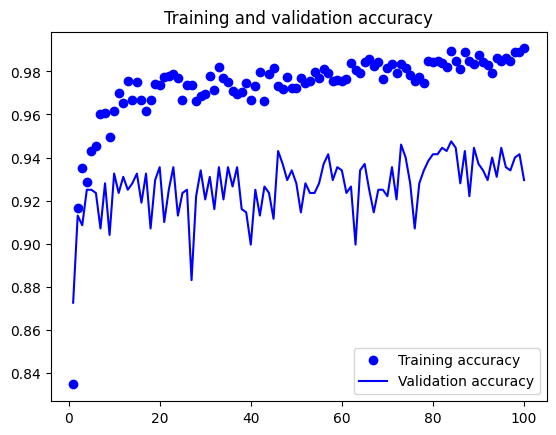

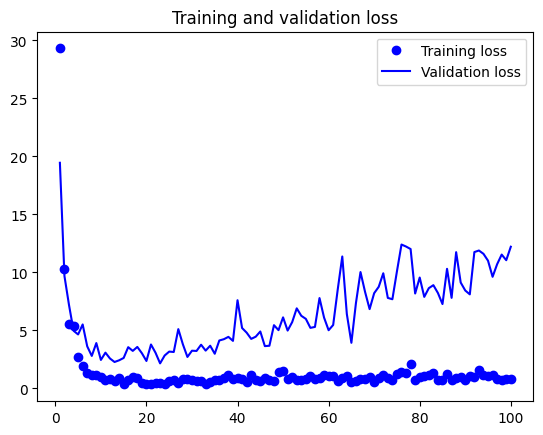

In [14]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

#### Saving the Model

In [15]:
save_path = '../3. Model Selection/saved_models/Model 3-Zero-padded Data Transfer Learning Model/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
save_model(model, save_path)

Saved model to disk


In [17]:
#below saved files are gitignored

In [16]:
if not os.path.exists('./saved_models/Zero-padded Transfer Learning Model'):
    os.makedirs('./saved_models/Zero-padded Transfer Learning Model')
model.save('./saved_models/Zero-padded Transfer Learning Model')